# Thinkful Final Capstone -- Classifying Galaxy Images



The universe is an unimaginably large place.  In our galaxy alone, there are between 100 billion and 400 billion stars (there are so many and they are packed so densely that this is the closest range astronomers can give for its size).  And there are approximately 100 billion galaxies in the universe, each with about 100 billion stars.  That's 10,000,000,000,000,000,000,000 stars, more than all the grains of sand on all of earth's beaches!

This project is based on a data set from an old Kaggle competition that was sponsored by the Galaxy Zoo Project, a crowd-source volunteer project that was started in 2007, to help classify hundreds of thousands of galaxy images that had been collected by multiple research telescopes around the world.  The dataset I'm using contains 60,000 images of galaxies and I will be performing multiple classifications of types and features, using neural networks via TensorFlow/Keras.  The data set includes a spreadsheet of numerical averages of 37 separate classes of galaxy types/features.  Each galaxy has an average score for each class based on the respondents' replies.  

My project takes the data set and makes predictions on multiple categories:
- First level:  is the image of a galaxy that's smooth & round, or does it have features, or is it not a galaxy?
- Second level: (1) if it's smooth and round, how round is it?    (2) Is the image of an edge-on galaxy?
- Third level: If the galaxy is not smooth/round and is not edge-on, does it have a spiral pattern?

Enjoy!

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
import keras
import time
import skimage
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg


#from PIL import Image
import glob, os
import cv2
import concurrent.futures
import pandas as pd
import pickle

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
#from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop, SGD, Adagrad, Adadelta, Adam, Adamax
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from statistics import mean

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Import the backend
from keras import backend as K



Using TensorFlow backend.


In [2]:
results=[]   # This is a list results of testing that will stored in a file for retrival

<font color=blue>
This function takes all 60,000 images given the file path, and converts them into arrays for processing.  The file is read 
using OpenCV, a library of programming functions mainly aimed at real-time computer vision.  Each image is read, re-sized, and cropped (we only need the center portion of the image) to accelerate processing.<br>

Note: After reading in the files, I pickle the array and used that for computation, as there's no need to keep processing the images themselves.


In [3]:
def image_array(path,size):
    files=glob.glob(path)   # enables me to read in the full folder of images
    images=[]
    for count,file in enumerate(files):     
        img = cv2.imread(file)
        img = cv2.resize(img, (size, size)) 
        crop = int(size/4)   # we only need the center of the picture to analyze the galaxy
        img = img[crop:crop*3,crop:crop*3].copy()
        images.append(img)
        if count%500 == 0:
            print(count)
    return np.asarray(images)  # turns list into array

<font color=blue> Below is the code that calls "image_array", for reference, but as mentioned I only need to do it once and then I can pickle the file.

In [ ]:
# This is the code that calls "image_array", for reference, but as mentioned I only need to do it
# once and then I can pickle the file.
picture_size = 100  # This is one side of the picture in pixels

x_train_path = 'C:/Thinkful/galaxy-zoo-the-galaxy-challenge/images_training_rev1/*.jpg'
x_train_full = image_array(x_train_path,picture_size)   # store for future processing

with open("c:/Thinkful/galaxy-zoo-the-galaxy-challenge/x_train_full_100.p", 'wb') as fp:
    pickle.dump(results, fp)

<font color=blue> Let's look at a typical galaxy picture

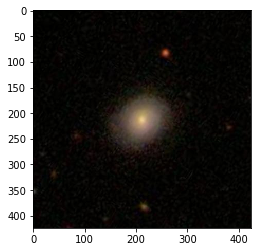

In [4]:
img=mpimg.imread('C:/Thinkful/galaxy-zoo-the-galaxy-challenge/images_training_rev1/100008.jpg')
imgplot = plt.imshow(img)

In [12]:
x_train_full = pickle.load( open( "c:/Thinkful/galaxy-zoo-the-galaxy-challenge/x_train_full_100.p","rb" ))

<font color=blue>  This shows distribution of the various types of galaxies that I'm analyzing

In [89]:
def plot_response_baseline(df):

    fig = plt.figure(figsize=(12,8))
    minimum_response = .45

    round_galaxy = len(df[df['Class1.1'] > minimum_response])
    features_galaxy = len(df[df['Class1.2'] > minimum_response])
    galaxy_counts1=[('Round',round_galaxy),('Features',features_galaxy),('Non',non_galaxy)]
    labels, ys = zip(*galaxy_counts1)
    xs = np.arange(len(labels)) 
    width = .5
    ax1 = fig.add_subplot(221)
    plt.bar(xs, ys, width, align='center',color='blue')

    complete_round = len(df[(df['Class1.1'] >= minimum_response) & df['Class7.1'] > (minimum_response * df['Class1.1'])])
    oval = len(df[(df['Class1.1'] >= minimum_response) & df['Class7.2'] > (minimum_response * df['Class1.1'])])
    cigar_shape = len(df[(df['Class1.1'] >= minimum_response) & df['Class7.3'] > (minimum_response * df['Class1.1'])])
    galaxy_counts2=[('Full Round',complete_round),('Oval',oval),('Cigar-shaped',cigar_shape)]
    labels, ys = zip(*galaxy_counts2)
    xs = np.arange(len(labels)) 
    width = .5
    ax2 = fig.add_subplot(222)
    plt.bar(xs, ys, width, align='center',color='red')

    
    edge_on = len(df[(df['Class1.2'] >= minimum_response) & (df['Class2.1'] > (minimum_response * df['Class1.2']))])
    not_edge_on = len(df[(df['Class1.2'] >= minimum_response) & df['Class2.2'] > (minimum_response * df['Class1.2'])])
    galaxy_counts3=[('Edge-on',edge_on),('Not edge-on',not_edge_on)]
    labels, ys = zip(*galaxy_counts3)
    xs = np.arange(len(labels)) 
    width = .5
    ax3 = fig.add_subplot(223)
    plt.bar(xs, ys, width, align='center',color='green')
    

    spiral = len(df[(class22 >= minimum_response) & (df['Class4.1'] > minimum_response * class22)])
    non_spiral = len(df[(class22 >= minimum_response) & (df['Class4.2'] > minimum_response * class22)])
    galaxy_counts4=[('Spiral',spiral),('Non-spiral',non_spiral)]
    labels, ys = zip(*galaxy_counts4)
    xs = np.arange(len(labels)) 
    width = .5
    ax4 = fig.add_subplot(224)
    plt.bar(xs, ys, width, align='center',color='orange')

    ax1.title.set_text('First Level--Smooth, Features, Non-Galaxy')
    ax2.title.set_text('Second Level--Round, Oval, Cigar-shape')
    ax3.title.set_text('Second Level--Edge-on, Not Edge-on')
    ax4.title.set_text('Third Level--Spiral, Non-Spiral')

    plt.show()
    


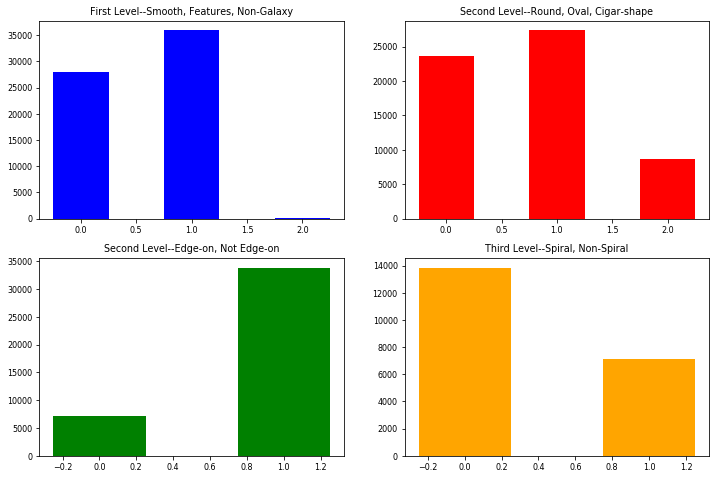

In [90]:
#y_train_full = pd.read_csv('C:/Thinkful/galaxy-zoo-the-galaxy-challenge/training_solutions_rev1.csv')
df = pd.read_csv('C:/Thinkful/galaxy-zoo-the-galaxy-challenge/training_solutions_rev1.csv')[:60000]
plot_response_baseline(df)

<font color=blue>  This function finds the maximum value of the first level (smooth/round, features/disk, not a galaxy).  It then assigns that value with a one and marks the other two categories with a 0.  "minimum_response" denotes what is the minimum average for the three categories, e.g., if minimum_response = 0.7 (meaning at least 70% of respondents said a galaxy is in one of the categories), only images that have a least a 0.7 score in one of the three categories will be used, otherwise the image is removed from the dataframe.  The index of any row that does not meet the minimum response is stored in a list and returned.

In [5]:
def find_max_first_level(df,minimum_response):
    df['Class1.1'] = (df['Class1.1'] >= minimum_response).astype(int)
    df['Class1.2'] = (df['Class1.2'] >= minimum_response).astype(int)
    df['Class1.3'] = (df['Class1.3'] >= minimum_response).astype(int)

    remove_rows = df.index[(df['Class1.1']==0) & (df['Class1.2']==0) & (df['Class1.3']==0)].tolist()

    return(df,remove_rows)

<font color=blue>This function does the same thing as the function above, but the classes are expanded for the second level (how round; edge-on or not).

In [6]:
def find_max_second_level(df,minimum_response):
    df['Class1.3'] = (df['Class1.3'] >= minimum_response).astype(int)

    class21_min = minimum_response * df['Class1.2']
    
    df['Class2.1'] = ((df['Class1.2'] >= minimum_response) & (df['Class2.1'] >= minimum_response * df['Class1.2'])).astype(int)
    df['Class2.2'] = ((df['Class1.2'] >= minimum_response) & (df['Class2.2'] >= minimum_response * df['Class1.2'])).astype(int)

    df['Class7.1'] = ((df['Class1.1'] >= minimum_response) & (df['Class7.1'] >= minimum_response * df['Class1.1'])).astype(int)
    df['Class7.2'] = ((df['Class1.1'] >= minimum_response) & (df['Class7.2'] >= minimum_response * df['Class1.1'])).astype(int)
    df['Class7.3'] = ((df['Class1.1'] >= minimum_response) & (df['Class7.3'] >= minimum_response * df['Class1.1'])).astype(int)

    remove_rows = df.index[(df['Class1.3']==0) & (df['Class2.1']==0) & (df['Class2.2']==0) & (df['Class7.1']==0) &
                           (df['Class7.2']==0) & (df['Class7.3']==0)].tolist()
    
    return(df,remove_rows)

<font color=blue>  And this one computes the third level.  :)

In [7]:
def find_max_third_level(df,minimum_response):
    df['Class1.3'] = (df['Class1.3'] >= minimum_response).astype(int)

    class21_min = minimum_response * df['Class1.2']
    class22_min = minimum_response * df['Class1.2']

    class41_min = minimum_response * class22_min
    class42_min = minimum_response * class22_min

    class71_min = minimum_response * df['Class1.1']
    class72_min = minimum_response * df['Class1.1']
    class73_min = minimum_response * df['Class1.1']
    
    df['Class2.1'] = ((df['Class1.2'] >= minimum_response) & (df['Class2.1'] >= class21_min)).astype(int)

    df['Class4.1'] = ((df['Class2.2'] >= minimum_response) & 
                      (df['Class4.1'] >= class41_min)).astype(int)
    
    df['Class4.2'] = ((df['Class2.2'] >= minimum_response) & 
                      (df['Class4.2'] >= class42_min)).astype(int)

    df['Class7.1'] = ((df['Class1.1'] >= minimum_response) & 
                      (df['Class7.1'] >= class71_min)).astype(int)
    df['Class7.2'] = ((df['Class1.1'] >= minimum_response) & 
                      (df['Class7.2'] >= class72_min)).astype(int)
    df['Class7.3'] = ((df['Class1.1'] >= minimum_response) & 
                      (df['Class7.3'] >= class73_min)).astype(int)

    remove_rows = df.index[(df['Class1.3']==0) & (df['Class2.1']==0) & 
                           (df['Class4.1']==0) & (df['Class4.2']==0) & 
                           (df['Class7.1']==0) & (df['Class7.2']==0) & (df['Class7.3']==0)].tolist()
    return(df,remove_rows)

<font color=blue> The function below is where I call the "find_max" level functions, and store the indices of the rows in the dataframe that don't meet the minimum_response requirement.  "y_array" is the dataframe of the spreadsheet with all the responses.  "x_array" is the array of all the images converted via OpenCV.

In [8]:
def remove_row(x_array,y_array,level,minimum_response):
    if level == 'first':
        y_array,remove_rows = find_max_first_level(y_array, minimum_response)
    elif level == 'second':
        y_array,remove_rows = find_max_second_level(y_array, minimum_response)
    elif level == 'third':
        y_array,remove_rows = find_max_third_level(y_array, minimum_response)
   
    y_array = y_array.drop(remove_rows)
    remove_rows.reverse()  # since the indices in an array are different than a dataframe, we have to delete from the bottom up.
    x_array = np.delete(x_array,remove_rows, axis = 0)
    return x_array, y_array

<font color=blue> This function resets the training, validation and test sets for when I run multiple tests in a loop.

In [9]:
def reset_sets(x_train_full,set_sizes,minimum_response,level):
    train_size=set_sizes[0]
    validate_size=set_sizes[1]           # set_sizes is used to store lengths of all sets for calculation
    test_size=set_sizes[2]
    
    x_train = x_train_full[:train_size]
    x_validate = x_train_full[train_size:train_size+validate_size]
    x_test = x_train_full[-test_size:]
    
# Read in the solutions file and process

    y_train_full = pd.read_csv('C:/Thinkful/galaxy-zoo-the-galaxy-challenge/training_solutions_rev1.csv')
    if level == 'first':  # predicting three classes
        y_train_full = y_train_full[['Class1.1','Class1.2','Class1.3']]
        drop_columns=[]
    elif level == 'second':  # predicting six classes
        y_train_full = y_train_full[['Class1.1','Class1.2','Class1.3','Class2.1','Class2.2','Class7.1','Class7.2','Class7.3']]
        drop_columns=['Class1.1','Class1.2']  # drop these columns because they're replaced with classes 2 and 7
    elif level == 'third':  # predicting seven classes 1.3 in first level, 2.1 in second level (don't need 1.1 and 1.2)
        y_train_full = y_train_full[['Class1.1','Class1.2','Class1.3','Class2.1','Class2.2','Class4.1','Class4.2','Class7.1',
                                     'Class7.2','Class7.3']]
        drop_columns=['Class1.1','Class1.2','Class2.2'] #drop these columns because they're replaced with classes 2, 4 and 7
    else:
        print('invalid level')

    y_train = y_train_full[:train_size]  
    y_validate = y_train_full[train_size:train_size+validate_size].reset_index().drop(['index'],1) 
    y_test = y_train_full[-test_size:].reset_index().drop(['index'],1)  # have to reset index back to 0

    # Remove corresponding rows of images that don't match the prediction parameter percentage
    x_train,y_train = remove_row(x_train,y_train,level,minimum_response)   # remove
    x_validate, y_validate = remove_row(x_validate,y_validate,level,minimum_response)
    x_test,y_test = remove_row(x_test,y_test,level,minimum_response)
    
    y_train = y_train.drop(columns=drop_columns).to_numpy()    #drop the columns and convert from df to array for processing
    y_validate = y_validate.drop(columns=drop_columns).to_numpy()  
    y_test = y_test.drop(columns=drop_columns).to_numpy()  

    return x_train,x_validate,x_test,y_train,y_validate,y_test

<font color = blue>  Now for the heavy stuff.  Here's the final model I used (after many, many iterations and tweaks).

# Convolutional

In [11]:
def Conv_net(x_train_full,set_sizes,start_layer,batch_size,epoch_num,optimizer,optimizer_name,
             minimum_response,picture_size,level,num_layers):
    
    start=time.time()
    
    x_train,x_validate,x_test,y_train,y_validate,y_test = reset_sets(x_train_full,set_sizes,minimum_response,level)
    print('Train:',x_train.shape[0],'Test:',x_validate.shape[0])
    num_classes = y_test.shape[1]
    new_set_sizes=[x_train.shape[0],x_validate.shape[0],x_test.shape[0]]

    # Convert to float32 for type consistency
    x_train = x_train.astype('float32')
    x_validate = x_validate.astype('float32')
    x_test = x_test.astype('float32')

    # Normalize values to 1 from 0 to 255 (256 validateues of pixels)
    x_train /= 255
    x_validate /= 255
    x_test /= 255

    img_rows, img_cols = int(picture_size/2), int(picture_size/2)  # picture size is original resize, but we cropped the middle

    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_validate = x_validate.reshape(x_validate.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

    
    # Building the Model
    model = Sequential()

#  In the statement below, if "large" is passed into the function, then I do a VGG16-like method, which takes several 
#  convolutional layers, then maxpooling and dropout, and repeats this twice, increasing the number of layers and the
#  number of neurons per layer.  Then flatten the file and add the final dense layer for prediction.  Padding is added
#  to prevent errors in processing.  If "small" is passed, then I just do a simple 3-layer conv neural network
    
    if num_layers == 'large':
        model.add(Conv2D(start_layer, kernel_size=(3, 3),
                         activation='relu',
                         input_shape=input_shape, padding='same'))  # padding='same'
        model.add(Conv2D(start_layer, (3, 3), activation='relu', padding='same'))  #, padding='same'))  # padding='same'
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(start_layer*2, (3, 3), activation='relu', padding='same'))  #, padding='same'))
        model.add(Conv2D(start_layer*2, (3, 3), activation='relu', padding='same'))  #, padding='same'))
        model.add(Conv2D(start_layer*2, (3, 3), activation='relu', padding='same'))  #, padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(start_layer*4, (3, 3), activation='relu', padding='same'))  #, padding='same'))
        model.add(Conv2D(start_layer*4, (3, 3), activation='relu', padding='same'))  #, padding='same'))
        model.add(Conv2D(start_layer*4, (3, 3), activation='relu', padding='same'))  #, padding='same'))
        model.add(Conv2D(start_layer*4, (3, 3), activation='relu', padding='same'))  #, padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(start_layer*8, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation='softmax'))
    else:
        model.add(Conv2D(start_layer, kernel_size=(3, 3),
                         activation='relu',
                         input_shape=input_shape, padding='same'))  # padding='same'
        model.add(Dropout(0.2))
        model.add(Conv2D(start_layer*2, (3, 3), activation='relu', padding='same'))  #, padding='same'))
        model.add(Dropout(0.2))
        model.add(Conv2D(start_layer*4, (3, 3), activation='relu', padding='same'))  #, padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(start_layer*4, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation='softmax'))

    # Compile the model to put it all together.
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, 
                               restore_best_weights=False)
    callbacks_list = [early_stop]
    
    conv_history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epoch_num,
                            callbacks=callbacks_list,
                            verbose=1,
                            validation_data=(x_validate, y_validate))

    score1 = model.evaluate(x_validate, y_validate, verbose=0)
    predictions = model.predict(x_test)
    score2 = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score1[0],score2[0])
    print('Test accuracy:', score1[1],score2[1])
    end = time.time()-start
    print('Time = %d mins %d seconds' % (int(end/60), int(end%60)))  
    
    sets = [x_train,x_validate,x_test,y_train,y_validate,y_test]
#   "results" is a list of all the parameters, scores, etc. that I keep track of.  They are appended in a pickle file (below)

    results = [picture_size,optimizer_name,num_layers,level,minimum_response,new_set_sizes,start_layer,epoch_num,score1,score2,end]

    return conv_history,results,predictions,sets

<font color=blue>  Below is where I set up the various parameters and run the model.  Note that I've set up a big loop so that it can iterate through multiple parameters to give me the results I need

In [12]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# This is the file where all 60,000 images are stored as arrays, so I don't have to read in every image every time
x_train_full = pickle.load( open( "c:/Thinkful/galaxy-zoo-the-galaxy-challenge/x_train_full_100.p","rb" ))

picture_size =100

train_size = 40000
validate_size = int(train_size/4)  # I have validate and test as variables in case I don't want to test on the whole dataset
test_size = int(train_size/4)
level = ['first','second','third']  # This is the level of classes I'm predicting
minimum_response = [.4,.5,.6,.7,.8,.9]   # This denotes the minimum response in the various columns
set_sizes = [train_size,validate_size,test_size]  # This passes the size of the sets to other functions

start_layers = [32,64]  # number of neurons in the first layer of the convolutional network
batch_size = [64,128]   # batch size
epoch_num = [20,30,40,60]  # This enables me to iterate cross multiple numbers of epochs.  I use this occasionally to
                           # compare results with EarlyStopping
num_layers = ['large','small']  # "large" = VGG-like model, "small" = simple 3-layer model

optimizer = [RMSprop(), SGD(), Adagrad(), Adadelta(), Adam(), Adamax()]   # This enables me to iterate across multiple optimizers
optimizer_name = ['RMSprop', 'SGD', 'Adagrad', 'Adadelta', 'Adam', 'Adamax'] # store the name to include in file names

#for i in range (len(level)):
#    for j in range(len(minimum_response)):
for k in range(3,len(minimum_response)-2):
    for l in range(1,len(level)-1):
        conv_netw,result,predictions,sets = Conv_net(x_train_full,set_sizes,start_layers[0],batch_size[0],epoch_num[2],optimizer[5],
                                                optimizer_name[5],minimum_response[k],picture_size,level[l],num_layers[0])
                    
        history_name = "c:/Thinkful/galaxy-zoo-the-galaxy-challenge/history_"+optimizer_name[5]+str(minimum_response[k])+\
                    str(epoch_num[2])+str(start_layers[0])+"-0909.p"
        with open(history_name, 'wb') as fp:
            pickle.dump(conv_netw, fp)
                
        results = pickle.load( open( "c:/Thinkful/galaxy-zoo-the-galaxy-challenge/results_0912.p","rb" ))
        results.append(result)
        with open("c:/Thinkful/galaxy-zoo-the-galaxy-challenge/results_0912.p", 'wb') as fp:
            pickle.dump(results, fp)


Train: 20173 Test: 5028


W0912 17:44:10.483496 39104 deprecation_wrapper.py:119] From c:\users\jb\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0912 17:44:10.486500 39104 deprecation_wrapper.py:119] From c:\users\jb\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0912 17:44:10.490446 39104 deprecation_wrapper.py:119] From c:\users\jb\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0912 17:44:10.513382 39104 deprecation_wrapper.py:119] From c:\users\jb\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf

Train on 20173 samples, validate on 5028 samples
Epoch 1/40
20173/20173 [==============================] - 28s 1ms/step - loss: 1.0958 - acc: 0.5819 - val_loss: 0.8677 - val_acc: 0.6651
Epoch 2/40
20173/20173 [==============================] - 22s 1ms/step - loss: 0.7145 - acc: 0.7236 - val_loss: 0.6046 - val_acc: 0.7548
Epoch 3/40
20173/20173 [==============================] - 22s 1ms/step - loss: 0.6131 - acc: 0.7655 - val_loss: 0.5663 - val_acc: 0.7796
Epoch 4/40
20173/20173 [==============================] - 22s 1ms/step - loss: 0.5300 - acc: 0.8034 - val_loss: 0.4248 - val_acc: 0.8435
Epoch 5/40
20173/20173 [==============================] - 22s 1ms/step - loss: 0.4372 - acc: 0.8428 - val_loss: 0.3509 - val_acc: 0.8757
Epoch 6/40
20173/20173 [==============================] - 22s 1ms/step - loss: 0.3698 - acc: 0.8703 - val_loss: 0.2834 - val_acc: 0.9000
Epoch 7/40
20173/20173 [==============================] - 22s 1ms/step - loss: 0.3294 - acc: 0.8826 - val_loss: 0.3907 - val_acc:

In [33]:
results1

[100,
 'Adamax',
 'large',
 'first',
 0.7,
 [10000, 2500, 2500],
 32,
 20,
 [0.35714448034363305, 0.8422818793546434],
 [0.41272415375231103, 0.8234113715564129],
 110.26085257530212,
 [100,
  'RMSprop',
  'large',
  'first',
  0.7,
  [10000, 2500, 2500],
  32,
  20,
  [0.29444129899044164, 0.8979865768611831],
  [0.3353908764578427, 0.8655518397838375],
  99.18519377708435],
 [100,
  'SGD',
  'large',
  'first',
  0.7,
  [10000, 2500, 2500],
  32,
  20,
  [0.5208625788656657, 0.7751677855549243],
  [0.5577870590431634, 0.7404682271456638],
  119.63503384590149],
 [100,
  'Adagrad',
  'large',
  'first',
  0.7,
  [10000, 2500, 2500],
  32,
  20,
  [6.155165313234265, 0.6181208056091462],
  [6.4472382057470625, 0.5999999997807187],
  40.97580671310425],
 [100,
  'Adadelta',
  'large',
  'first',
  0.7,
  [10000, 2500, 2500],
  32,
  20,
  [0.3409978332935564, 0.8785234897728734],
  [0.3811949514625064, 0.8461538464728008],
  125.55320978164673],
 [100,
  'Adam',
  'large',
  'first',
  

In [76]:
print(predictions[0])

[4.7679977e-16 1.3211817e-13 9.9997628e-01 2.3737497e-05 1.9308626e-13
 1.7761202e-08 1.7087628e-15]


In [73]:
# Pickle file that stored my optimizer loop results
opt_results = pickle.load( open( "c:/Thinkful/galaxy-zoo-the-galaxy-challenge/opt_results_0909.p","rb" ))

In [131]:
opt_results

[['RMSprop',
  [0.29444129899044164, 0.8979865768611831],
  [0.3353908764578427, 0.8655518397838375]],
 ['SGD',
  [0.5208625788656657, 0.7751677855549243],
  [0.5577870590431634, 0.7404682271456638]],
 ['Adagrad',
  [6.155165313234265, 0.6181208056091462],
  [6.4472382057470625, 0.5999999997807187]],
 ['Adadelta',
  [0.3409978332935564, 0.8785234897728734],
  [0.3811949514625064, 0.8461538464728008]],
 ['Adam',
  [0.14021776630574426, 0.948993288270579],
  [0.19568602423305098, 0.9297658862876255]],
 ['Adamax',
  [0.1639570461023574, 0.9449664427130015],
  [0.2161076618240131, 0.9190635451505017]]]

<font color=blue>  Here's a couple graphs showing training accuracy during the epochs.  You can see that it typically stopped training at around 20 epochs, so I just started using EarlyStopping

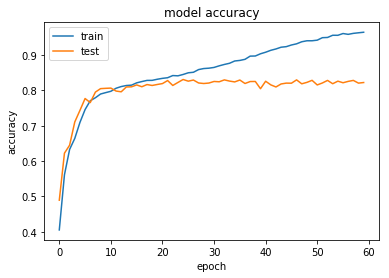

In [312]:
plt.plot(results[7].history['acc'])
plt.plot(results[7].history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

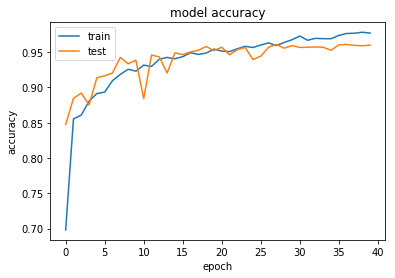

In [129]:
plt.plot(conv_netw.history['acc'])
plt.plot(conv_netw.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

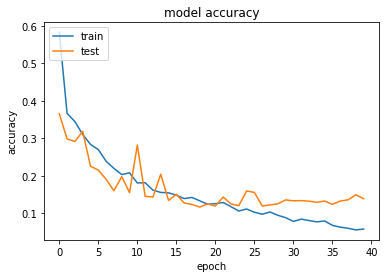

In [130]:
plt.plot(conv_netw.history['loss'])
plt.plot(conv_netw.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
mlp_results = ['START']
with open("c:/Thinkful/galaxy-zoo-the-galaxy-challenge/mlp_results_0909.p", 'wb') as fp:
     pickle.dump(mlp_results, fp)

<font color=blue>  Here's the code where I ran MLP for comparison

# MLP

Parmeters:  # neurons in each pass, batch size, number of epochs, optimizer

In [72]:
def MLP(x_train_full,set_sizes,start_layer,batch_size,epoch_num,optimizer,level,minimum_response,picture_size):
    # Add dense layers to create a fully connected MLP
    # Note that we specify an input shape for the first layer, but only the first layer.
    # Relu is the activation function used
    start=time.time()
    
    x_train,x_validate,x_test,y_train,y_validate,y_test = reset_sets(x_train_full,set_sizes,minimum_response,level)
    
    num_classes = y_test.shape[1]

    size = int(picture_size ** 2 / 4 * 3)   # using central portion of the picture

    # Our images will be picture_size ** 2

    x_train = x_train.reshape(len(x_train), size)
    x_validate = x_validate.reshape(len(x_validate), size)
    x_test = x_test.reshape(len(x_test), size)

    # Convert to float32 for type consistency
    x_train = x_train.astype('float32')
    x_validate = x_validate.astype('float32')
    x_test = x_test.astype('float32')

    # Normalize values to 1 from 0 to 255 (256 values of pixels)
    x_train /= 255
    x_validate /= 255
    x_test /= 255

    # Print sample sizes
    print(x_train.shape[0], 'train samples')
    print(x_validate.shape[0], 'validation samples')
    print(x_test.shape[0], 'test samples')

    model = Sequential()
    
    model.add(Dense(start_layer, activation='relu', input_shape=(size,)))
    # Dropout layers remove features and fight overfitting
    model.add(Dropout(0.2))
    model.add(Dense(start_layer * 2, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(start_layer * 4, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))  # End with a number of units equal to the number of classes
                                                     # we have for our outcome

#    model.summary()

    # Compile the model to put it all together.
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='auto', baseline=None, 
                               restore_best_weights=False)
    callbacks_list = [early_stop]
    
    mlp_history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epoch_num,
                            callbacks=callbacks_list,
                            verbose=1,
                            validation_data=(x_validate, y_validate))
    score1 = model.evaluate(x_validate, y_validate, verbose=1)
    score2 = model.evaluate(x_test, y_test, verbose=0)
    y_predict = model.predict(x_test)  #stores predictions of model
    print('Test loss:', score1[0],score2[0])
    print('Test accuracy:', score1[1],score2[1])
    end = time.time()-start
    print('Time = %d mins %d seconds' % (int(end/60), int(end%60)))

    results = [picture_size,optimizer_name,num_layers,level,minimum_response,set_sizes,start_layer,epoch_num,score1,score2,end]

    return mlp_history, results, y_predict

# Call MLP

In [45]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

picture_size = 100
x_train_full = pickle.load( open( "c:/Thinkful/galaxy-zoo-the-galaxy-challenge/x_train_full_"+str(picture_size)+".p","rb" ))

#train_size = [10000,20000,40000]
train_size = 40000
validate_size = int(train_size/4)
test_size = int(train_size/4)
#level = ['first','second','third']  #  values are top_level, second_level, third_level
level = ['first','second','third']
minimum_response = [.4,.5,.6,.7,.8,.9]
set_sizes = [train_size,validate_size,test_size]

start_layers = [32,64,128]
batch_size = [64,128]
#epoch_num = [5,20,30,40,60,100]
epoch_num = [20,30,40,60]
optimizer = [Adagrad(), Adadelta(), Adam(), Adamax()]
num_layers = ['large','small']
start_layers = [32,64,128]
batch_size = [64,128]


for k in range(len(minimum_response)):
    for l in range(len(level)):
        mlp_history,result,predictions = MLP(x_train_full,set_sizes,start_layers[1],batch_size[0],epoch_num[1],optimizer[3],
                                                  level[l],minimum_response[k],picture_size)

        
        history_name = "c:/Thinkful/galaxy-zoo-the-galaxy-challenge/mlp_history_"+str(minimum_response[k])+\
                    '-'+str(epoch_num[1])+'-start'+str(start_layers[1])+'-'+level[l]+"-0909.p"
        with open(history_name, 'wb') as fp:
            pickle.dump(mlp_history, fp)
                
        mlp_results = pickle.load( open( "c:/Thinkful/galaxy-zoo-the-galaxy-challenge/results_0909.p","rb" ))
        mlp_results.append(result)
        with open("c:/Thinkful/galaxy-zoo-the-galaxy-challenge/mlp_results_0909.p", 'wb') as fp:
            pickle.dump(mlp_results, fp)




39986 train samples
9997 validation samples
9997 test samples
Train on 39986 samples, validate on 9997 samples
Epoch 1/30
39986/39986 [==============================] - 10s 262us/step - loss: 0.7553 - acc: 0.6607 - val_loss: 0.6873 - val_acc: 0.7227
Epoch 2/30
39986/39986 [==============================] - 6s 158us/step - loss: 0.6912 - acc: 0.7267 - val_loss: 0.6596 - val_acc: 0.7447
Epoch 3/30
39986/39986 [==============================] - 6s 160us/step - loss: 0.6692 - acc: 0.7419 - val_loss: 0.6497 - val_acc: 0.7413
Epoch 4/30
39986/39986 [==============================] - 6s 159us/step - loss: 0.6565 - acc: 0.7526 - val_loss: 0.6408 - val_acc: 0.7388
Epoch 5/30
39986/39986 [==============================] - 6s 162us/step - loss: 0.6478 - acc: 0.7576 - val_loss: 0.6288 - val_acc: 0.7576
Epoch 6/30
39986/39986 [==============================] - 6s 156us/step - loss: 0.6398 - acc: 0.7628 - val_loss: 0.6302 - val_acc: 0.7488
Epoch 7/30
39986/39986 [==============================] - 6s

39915/39915 [==============================] - 6s 161us/step - loss: 1.7862 - acc: 0.6143 - val_loss: 1.7359 - val_acc: 0.6210
Epoch 19/30
39915/39915 [==============================] - 6s 161us/step - loss: 1.7749 - acc: 0.6197 - val_loss: 1.7360 - val_acc: 0.6273
Epoch 20/30
9978/9978 [==============================] - 1s 119us/step
Test loss: 1.7559020146025663 1.7601660578648806
Test accuracy: 0.6341952295526997 0.6310358646397981
Time = 2 mins 18 seconds
39010 train samples
9719 validation samples
9744 test samples
Train on 39010 samples, validate on 9719 samples
Epoch 1/30
39010/39010 [==============================] - 11s 270us/step - loss: 0.6033 - acc: 0.7048 - val_loss: 0.5390 - val_acc: 0.7626
Epoch 2/30
39010/39010 [==============================] - 6s 159us/step - loss: 0.5316 - acc: 0.7569 - val_loss: 0.4935 - val_acc: 0.7859
Epoch 3/30
39010/39010 [==============================] - 7s 168us/step - loss: 0.5091 - acc: 0.7724 - val_loss: 0.4760 - val_acc: 0.7920
Epoch 4/30

Epoch 12/30
37193/37193 [==============================] - 6s 163us/step - loss: 1.2822 - acc: 0.6378 - val_loss: 1.2244 - val_acc: 0.6533
Epoch 13/30
37193/37193 [==============================] - 6s 162us/step - loss: 1.2704 - acc: 0.6435 - val_loss: 1.2484 - val_acc: 0.6191
Epoch 14/30
37193/37193 [==============================] - 6s 163us/step - loss: 1.2611 - acc: 0.6469 - val_loss: 1.2057 - val_acc: 0.6519
Epoch 15/30
37193/37193 [==============================] - 6s 163us/step - loss: 1.2507 - acc: 0.6486 - val_loss: 1.2214 - val_acc: 0.6469
Epoch 16/30
37193/37193 [==============================] - 6s 161us/step - loss: 1.2461 - acc: 0.6514 - val_loss: 1.2366 - val_acc: 0.6494
Epoch 17/30
37193/37193 [==============================] - 6s 163us/step - loss: 1.2370 - acc: 0.6514 - val_loss: 1.2113 - val_acc: 0.6479
Epoch 18/30
9288/9288 [==============================] - 1s 138us/step
Test loss: 1.250369867356454 1.2700451454362562
Test accuracy: 0.6236003445305771 0.62109668421

Epoch 11/30
27348/27348 [==============================] - 4s 152us/step - loss: 1.0190 - acc: 0.6938 - val_loss: 0.9358 - val_acc: 0.7122
Epoch 12/30
27348/27348 [==============================] - 4s 153us/step - loss: 1.0055 - acc: 0.6974 - val_loss: 0.9510 - val_acc: 0.7042
Epoch 13/30
27348/27348 [==============================] - 4s 153us/step - loss: 0.9939 - acc: 0.7039 - val_loss: 0.9963 - val_acc: 0.6848
Epoch 14/30
27348/27348 [==============================] - 4s 154us/step - loss: 0.9950 - acc: 0.7007 - val_loss: 0.9788 - val_acc: 0.6949
Epoch 15/30
27348/27348 [==============================] - 4s 153us/step - loss: 0.9754 - acc: 0.7070 - val_loss: 0.9256 - val_acc: 0.7157
Epoch 16/30
27348/27348 [==============================] - 4s 153us/step - loss: 0.9787 - acc: 0.7066 - val_loss: 0.9449 - val_acc: 0.7068
Epoch 17/30
27348/27348 [==============================] - 4s 153us/step - loss: 0.9613 - acc: 0.7123 - val_loss: 0.9375 - val_acc: 0.7132
Epoch 18/30
27348/27348 [==

18709 train samples
4686 validation samples
4661 test samples
Train on 18709 samples, validate on 4686 samples
Epoch 1/30
18709/18709 [==============================] - 8s 411us/step - loss: 1.3503 - acc: 0.4824 - val_loss: 1.0898 - val_acc: 0.5962
Epoch 2/30
18709/18709 [==============================] - 3s 162us/step - loss: 1.1011 - acc: 0.5853 - val_loss: 0.9836 - val_acc: 0.6283
Epoch 3/30
18709/18709 [==============================] - 3s 165us/step - loss: 1.0299 - acc: 0.6207 - val_loss: 0.8983 - val_acc: 0.6650
Epoch 4/30
18709/18709 [==============================] - 3s 156us/step - loss: 1.0008 - acc: 0.6347 - val_loss: 0.8354 - val_acc: 0.7106
Epoch 5/30
18709/18709 [==============================] - 3s 161us/step - loss: 0.9529 - acc: 0.6547 - val_loss: 0.8162 - val_acc: 0.7117
Epoch 6/30
18709/18709 [==============================] - 3s 157us/step - loss: 0.9257 - acc: 0.6648 - val_loss: 0.8021 - val_acc: 0.7125
Epoch 7/30
18709/18709 [==============================] - 3s 

Epoch 3/30
12332/12332 [==============================] - 2s 157us/step - loss: 0.6585 - acc: 0.7627 - val_loss: 0.5475 - val_acc: 0.7948
Epoch 4/30
12332/12332 [==============================] - 2s 157us/step - loss: 0.5875 - acc: 0.7889 - val_loss: 0.5083 - val_acc: 0.8091
Epoch 5/30
12332/12332 [==============================] - 2s 168us/step - loss: 0.5557 - acc: 0.8005 - val_loss: 0.5360 - val_acc: 0.7981
Epoch 6/30
12332/12332 [==============================] - 2s 161us/step - loss: 0.5291 - acc: 0.8123 - val_loss: 0.4462 - val_acc: 0.8386
Epoch 7/30
12332/12332 [==============================] - 2s 156us/step - loss: 0.4886 - acc: 0.8299 - val_loss: 0.4169 - val_acc: 0.8486
Epoch 8/30
12332/12332 [==============================] - 2s 154us/step - loss: 0.4619 - acc: 0.8397 - val_loss: 0.3962 - val_acc: 0.8606
Epoch 9/30
12332/12332 [==============================] - 2s 158us/step - loss: 0.4297 - acc: 0.8494 - val_loss: 0.3708 - val_acc: 0.8733
Epoch 10/30
12332/12332 [=========

1828/1828 [==============================] - 0s 132us/step
Test loss: 0.19764838470410986 0.20217940006152724
Test accuracy: 0.925054704595186 0.9176151761840675
Time = 0 mins 26 seconds
5526 train samples
1365 validation samples
1360 test samples
Train on 5526 samples, validate on 1365 samples
Epoch 1/30
5526/5526 [==============================] - 6s 1ms/step - loss: 0.7815 - acc: 0.7798 - val_loss: 0.5636 - val_acc: 0.7839
Epoch 2/30
5526/5526 [==============================] - 1s 163us/step - loss: 0.5230 - acc: 0.8216 - val_loss: 0.4918 - val_acc: 0.8359
Epoch 3/30
5526/5526 [==============================] - 1s 164us/step - loss: 0.4589 - acc: 0.8556 - val_loss: 0.4323 - val_acc: 0.8557
Epoch 4/30
5526/5526 [==============================] - 1s 175us/step - loss: 0.4257 - acc: 0.8636 - val_loss: 0.4043 - val_acc: 0.8740
Epoch 5/30
5526/5526 [==============================] - 1s 168us/step - loss: 0.3981 - acc: 0.8746 - val_loss: 0.3833 - val_acc: 0.8842
Epoch 6/30
5526/5526 [====

In [43]:
mlp_results

[100,
 'Adamax',
 'large',
 'first',
 0.7,
 [10000, 2500, 2500],
 32,
 20,
 [0.35714448034363305, 0.8422818793546434],
 [0.41272415375231103, 0.8234113715564129],
 110.26085257530212,
 [100,
  'RMSprop',
  'large',
  'first',
  0.7,
  [10000, 2500, 2500],
  32,
  20,
  [0.29444129899044164, 0.8979865768611831],
  [0.3353908764578427, 0.8655518397838375],
  99.18519377708435],
 [100,
  'SGD',
  'large',
  'first',
  0.7,
  [10000, 2500, 2500],
  32,
  20,
  [0.5208625788656657, 0.7751677855549243],
  [0.5577870590431634, 0.7404682271456638],
  119.63503384590149],
 [100,
  'Adagrad',
  'large',
  'first',
  0.7,
  [10000, 2500, 2500],
  32,
  20,
  [6.155165313234265, 0.6181208056091462],
  [6.4472382057470625, 0.5999999997807187],
  40.97580671310425],
 [100,
  'Adadelta',
  'large',
  'first',
  0.7,
  [10000, 2500, 2500],
  32,
  20,
  [0.3409978332935564, 0.8785234897728734],
  [0.3811949514625064, 0.8461538464728008],
  125.55320978164673],
 [100,
  'Adam',
  'large',
  'first',
  

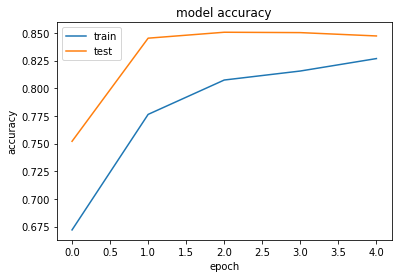

In [15]:
plt.plot(mlp_history.history['acc'])
plt.plot(mlp_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

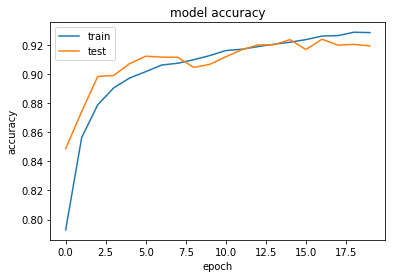

In [84]:
plt.plot(result1.history['acc'])
plt.plot(result1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("c:/Thinkful/galaxy-zoo-the-galaxy-challenge/history_"+result_str+".png") # save as file for use in deck
plt.show()

In [92]:
start=time.time()
df = pd.read_csv('C:/Thinkful/galaxy-zoo-the-galaxy-challenge/training_solutions_rev1.csv')[:60000]
print('time:',time.time()-start)
round_galaxy = len(df[(df['Class1.1'] > df['Class1.2']) & (df['Class1.1'] > df['Class1.3'])])
features_galaxy = len(df[(df['Class1.2'] > df['Class1.1']) & (df['Class1.2'] > df['Class1.3'])])
non_galaxy = len(df[(df['Class1.3'] > df['Class1.1']) & (df['Class1.3'] > df['Class1.2'])])
#df['Class1.1'] = (df['Class1.1'] >= .7).astype(int)
galaxy_counts=[('Round',round_galaxy),('Features',features_galaxy),('Non',non_galaxy)]

time: 0.350064754486084


<font color=blue>  This shows distribution of the galaxies in the various percentage levels

In [93]:
def plot_response_count(i,fig,num_graphs, galaxy_counts,minimum_response,color,level):
    labels, ys = zip(*galaxy_counts)
    xs = np.arange(len(labels)) 
    width = .5

    grid_row = 200  #  2-row grid
    
    grid_col = int(num_graphs/2) * 10  # (number of columns)
    grid = grid_row + grid_col + i + 1
    
    fig.add_subplot(grid)
    plt.bar(xs, ys, width, align='center',color=color)
    if level == 'First':
        title_str = 'First Level--Smooth, Features, Non-Galaxy'
    elif level == 'Second-Round':
        title_str = 'Second Level--Round, Oval, Cigar-shape'
    elif level == 'Second-Edge':
        title_str = 'Second Level--Edge-on, Not Edge-on'
    else:
        title_str = 'Third Level--Spiral, Non-Spiral'
        
    plt.rcParams.update({'font.size': 8})
#    plt.title(title_str + '(>'+str(int(minimum_response*100))+'%)')
    plt.title(title_str + '(>'+str(int(minimum_response*100))+'%)')
    plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
    plt.yticks(ys)
#    plt.show()
    return fig

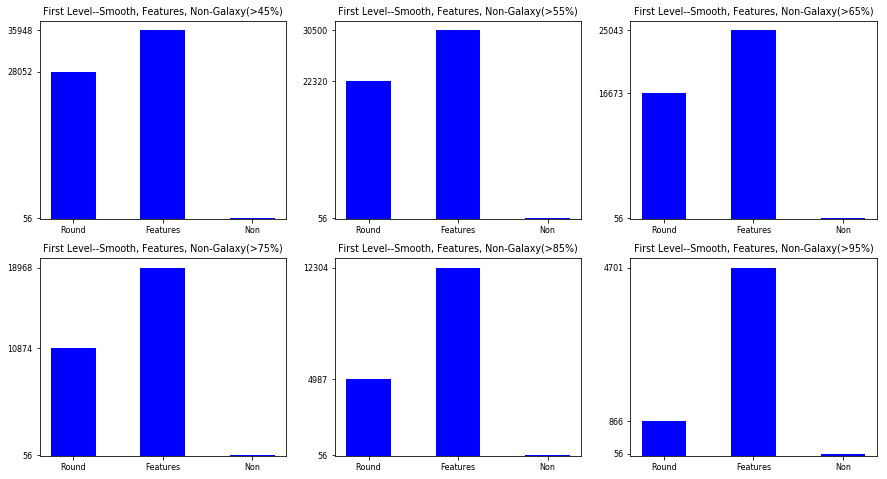

In [94]:
fig = plt.figure(figsize=(15,8))
num_graphs=6

for i in range(num_graphs):
    minimum_response = .45 + (i/10)
    round_galaxy = len(df[df['Class1.1'] > minimum_response])
    features_galaxy = len(df[df['Class1.2'] > minimum_response])
    
    galaxy_counts1=[('Round',round_galaxy),('Features',features_galaxy),('Non',non_galaxy)]
  
    fig = plot_response_count(i,fig,num_graphs,galaxy_counts1,minimum_response,'blue','First')
    plt.savefig("c:/thinkful/galaxy-zoo-the-galaxy-challenge/first_"+str(i)+".png") # save as file for use in deck

#plt.rcParams.update({'font.size': 20})
plt.show()

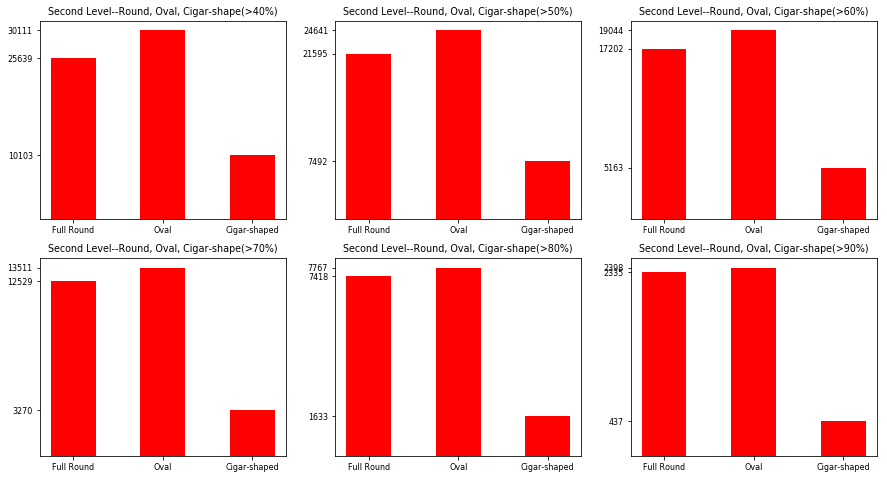

In [95]:
fig = plt.figure(figsize=(15,8))
num_graphs=6

for i in range(num_graphs):
    minimum_response = .4 + (i/10)
    complete_round = len(df[(df['Class1.1'] >= minimum_response) & df['Class7.1'] > (minimum_response * df['Class1.1'])])
    oval = len(df[(df['Class1.1'] >= minimum_response) & df['Class7.2'] > (minimum_response * df['Class1.1'])])
    cigar_shape = len(df[(df['Class1.1'] >= minimum_response) & df['Class7.3'] > (minimum_response * df['Class1.1'])])
 
    galaxy_counts2=[('Full Round',complete_round),('Oval',oval),('Cigar-shaped',cigar_shape)]
  
    fig = plot_response_count(i,fig,num_graphs,galaxy_counts2,minimum_response,'red','Second-Round')
    plt.savefig("c:/thinkful/galaxy-zoo-the-galaxy-challenge/second_round_"+str(i)+".png") # save as file for use in deck

plt.show()

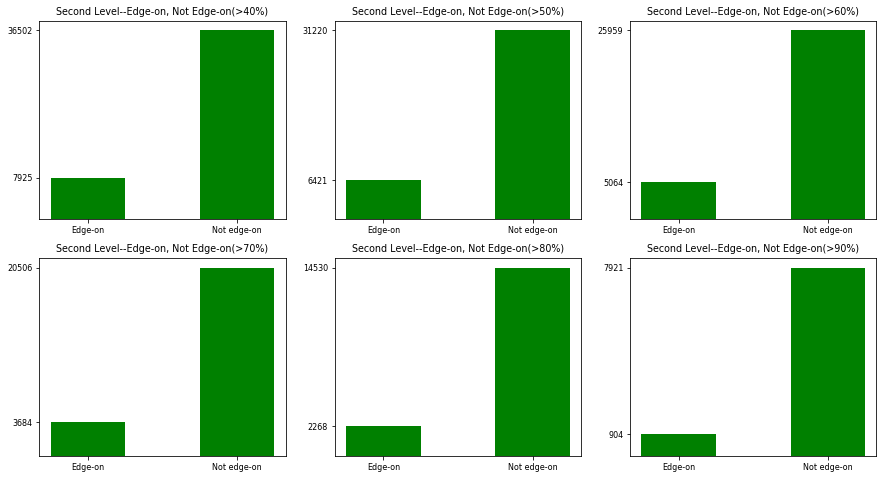

In [96]:
fig = plt.figure(figsize=(15,8))
num_graphs=6

for i in range(num_graphs):
    minimum_response = .4 + (i/10)
    edge_on = len(df[(df['Class1.2'] >= minimum_response) & (df['Class2.1'] > (minimum_response * df['Class1.2']))])
    not_edge_on = len(df[(df['Class1.2'] >= minimum_response) & df['Class2.2'] > (minimum_response * df['Class1.2'])])

    galaxy_counts3=[('Edge-on',edge_on),('Not edge-on',not_edge_on)]
  
    fig = plot_response_count(i,fig,num_graphs,galaxy_counts3,minimum_response,'green','Second-Edge')
    plt.savefig("c:/thinkful/galaxy-zoo-the-galaxy-challenge/second_edge_"+str(i)+".png") # save as file for use in deck

plt.show()

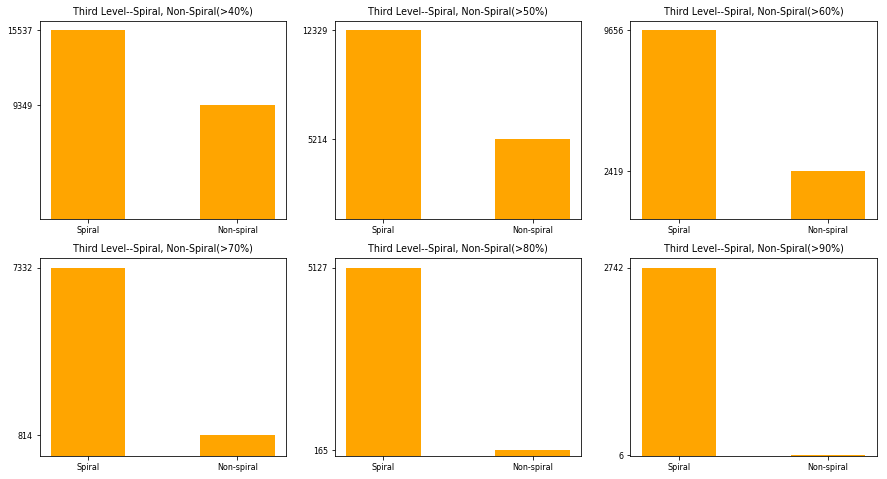

In [97]:
fig = plt.figure(figsize=(15,8))
num_graphs=6

class22 = df['Class2.2'] * df['Class1.2']

for i in range(num_graphs):
    minimum_response = .4 + (i/10)
    spiral = len(df[(class22 >= minimum_response) & (df['Class4.1'] > minimum_response * class22)])
    non_spiral = len(df[(class22 >= minimum_response) & (df['Class4.2'] > minimum_response * class22)])
 
    galaxy_counts4=[('Spiral',spiral),('Non-spiral',non_spiral)]
  
    fig = plot_response_count(i,fig,num_graphs,galaxy_counts4,minimum_response,'orange','Third')
    plt.savefig("c:/thinkful/galaxy-zoo-the-galaxy-challenge/third"+str(i)+".png") # save as file for use in deck

plt.show()

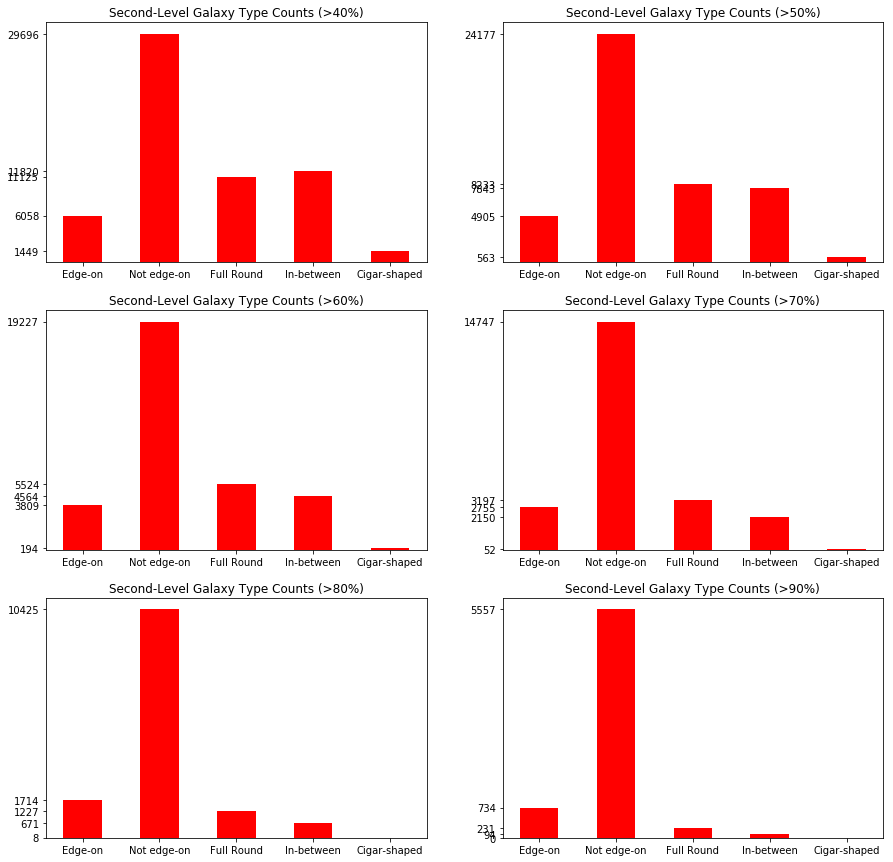

In [61]:
fig = plt.figure(figsize=(15,15))
num_graphs=6

for i in range(num_graphs):
    minimum_response = .4 + (i/10)
    edge_on = len(df[df['Class2.1'] > minimum_response])
    not_edge_on = len(df[df['Class2.2'] > minimum_response])
    complete_round = len(df[df['Class7.1'] > minimum_response])
    somewhat_round = len(df[df['Class7.2'] > minimum_response])
    cigar_shape = len(df[df['Class7.3'] > minimum_response])
    
 
    galaxy_counts2=[('Edge-on',edge_on),('Not edge-on',not_edge_on),
                    ('Full Round',complete_round),('In-between',somewhat_round),('Cigar-shaped',cigar_shape)]
  
    fig = plot_response_count(i,fig,num_graphs,galaxy_counts2,minimum_response,'red','Second')
plt.show()